<a href="https://colab.research.google.com/github/swilsonmfc/linear/blob/main/LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression
![](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Anscombe%27s_quartet_3.svg/1200px-Anscombe%27s_quartet_3.svg.png)

# Setup

In [1]:
import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling

from sklearn.datasets import load_boston
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError

import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.graphics.regressionplots as regplot
from statsmodels.stats.outliers_influence import variance_inflation_factor

from patsy import dmatrices

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
%matplotlib inline

# Data

In [3]:
boston = load_boston()
print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [4]:
bostonDF = pd.DataFrame(boston['data'], columns=boston['feature_names'])
bostonDF['TARGET'] = boston['target']
bostonDF.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## Categorical

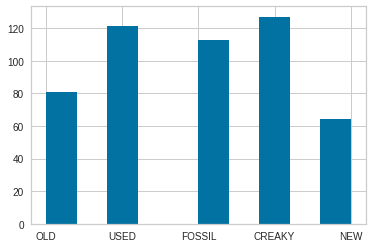

In [5]:
def ageBin(age):
    if age < 30: return 'NEW'
    if age < 60: return 'USED'
    if age < 80: return 'OLD'
    if age < 95: return 'CREAKY'
    return 'FOSSIL'
bostonDF['AGE_BIN'] = bostonDF['AGE'].apply(ageBin)
bostonDF['AGE_BIN'].hist()

## EDA

In [6]:
bostonDF

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET,AGE_BIN
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0,OLD
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6,OLD
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7,OLD
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4,USED
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2,USED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4,OLD
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6,OLD
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9,CREAKY
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0,CREAKY


In [7]:
bostonDF.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [8]:
bostonDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  TARGET   506 non-null    float64
 14  AGE_BIN  506 non-null    object 
dtypes: float64(14), object(1)
memory usage: 59.4+ KB


In [9]:
bostonDF.memory_usage(deep=True)

Index        128
CRIM        4048
ZN          4048
INDUS       4048
CHAS        4048
NOX         4048
RM          4048
AGE         4048
DIS         4048
RAD         4048
TAX         4048
PTRATIO     4048
B           4048
LSTAT       4048
TARGET      4048
AGE_BIN    42661
dtype: int64

# Preprocessing

In [10]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("The DataFrame does not include the columns: %s" % cols_error)


class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])

In [11]:
bostonDF['AGE_BIN'] = bostonDF['AGE_BIN'].astype('category')
bostonDF = bostonDF.drop('AGE', axis=1)

In [12]:
process = make_pipeline(
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            TypeSelector(np.number),
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            TypeSelector("category"),
            OneHotEncoder(categories='auto', drop='first')
        ))
    ])
)


# Loss Metrics

![](https://blog.hackerearth.com/wp-content/uploads/2016/12/anat.png)

## Explained Variance
* Talking point - What is R-Squared?
* ESS / TSS

## Mean Absolute Error
* Measures average model bias
* Easy to explain

![](https://miro.medium.com/max/630/1*OVlFLnMwHDx08PHzqlBDag.gif)

## Root Mean Squared Error
* In the same units of the prediction
* Measures the average magnitude of the error
* Larger errors result in larger RMSE (from squaring the term)

![](https://miro.medium.com/max/654/1*9hQVcasuwx5ddq_s3MFCyw.gif)

## Comparison

# ![](https://miro.medium.com/max/1400/1*YTxb8K2XZIisC944v6rERw.png)

## Mean Absolute Precision Error

![](https://channabasavagola.github.io/img/MAPE.jpeg)

## Guidance
![](https://www.researchgate.net/profile/Chao_Hung_Wang/publication/27219891/figure/tbl1/AS:394224022376454@1471001739320/MAPE-CRITERIA-FOR-MODEL-EVALUATION.png)

# Model

## Fit

In [13]:
df = bostonDF.copy()
y = df['TARGET']
X = df.drop('TARGET', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

clf = LinearRegression()
pipe = Pipeline(steps=[('process', process), ('regression', clf)])
pipe.fit(X_train, y_train)

pred = pipe.predict(X_test)
mae  = mean_absolute_error(y_test, pred)
mse  = mean_squared_error(y_test, pred)
rmse = math.sqrt(mse)

print('MAE  = {:.2f}'.format(mae))
print('MSE  = {:.2f}'.format(mse))
print('RMSE = {:.2f}'.format(rmse))

MAE  = 3.26
MSE  = 23.35
RMSE = 4.83


## Prediction Error

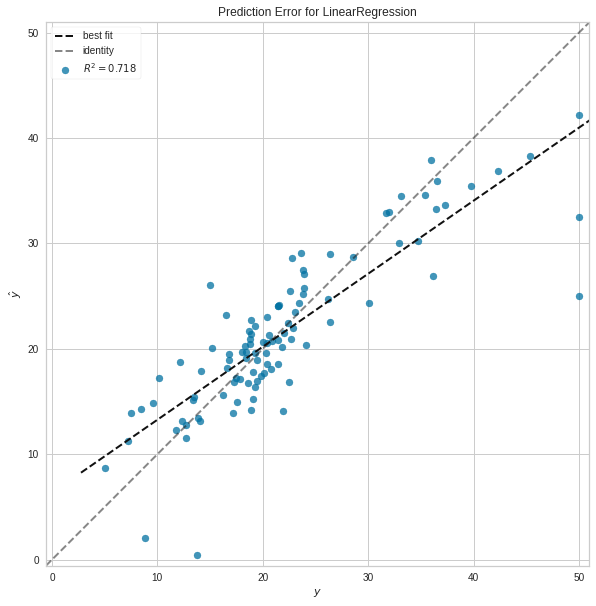

In [14]:
plt.figure(figsize=(15,10))
visualizer = PredictionError(pipe)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()   

## Residuals Plot

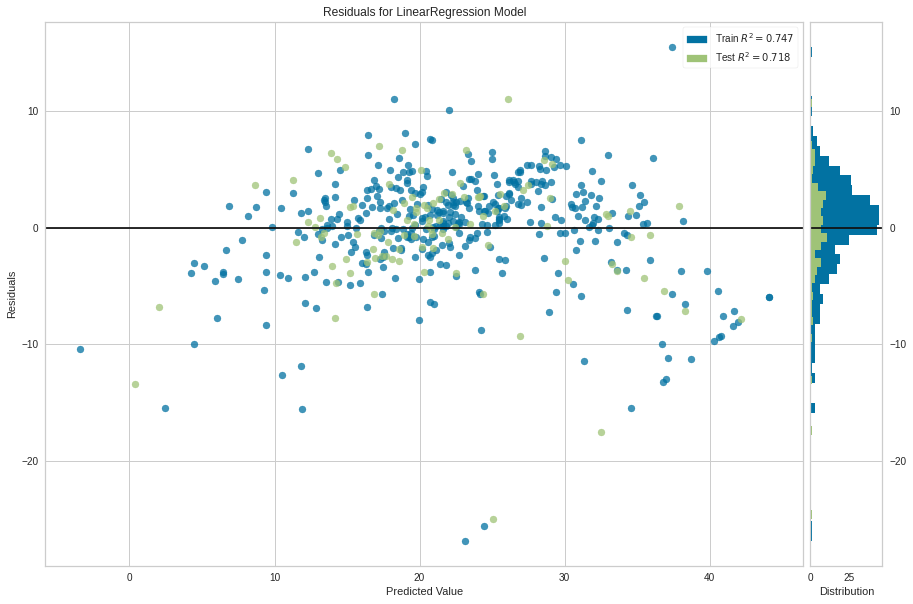

In [15]:
plt.figure(figsize=(15,10))
visualizer = ResidualsPlot(pipe)
visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof() 

# Interpretation

In [16]:
tDF = pd.concat([X_train, y_train], axis=1)
f = 'TARGET ~ CRIM + ZN + INDUS + CHAS + NOX + RM + DIS + RAD + TAX + PTRATIO + B + LSTAT + AGE_BIN'
lm = smf.ols(formula=f, data=tDF).fit()

In [17]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                 TARGET   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     71.45
Date:                Thu, 21 Jan 2021   Prob (F-statistic):          9.11e-105
Time:                        13:01:25   Log-Likelihood:                -1192.3
No. Observations:                 404   AIC:                             2419.
Df Residuals:                     387   BIC:                             2487.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            33.7007      5.97

## Partial Regression Plots

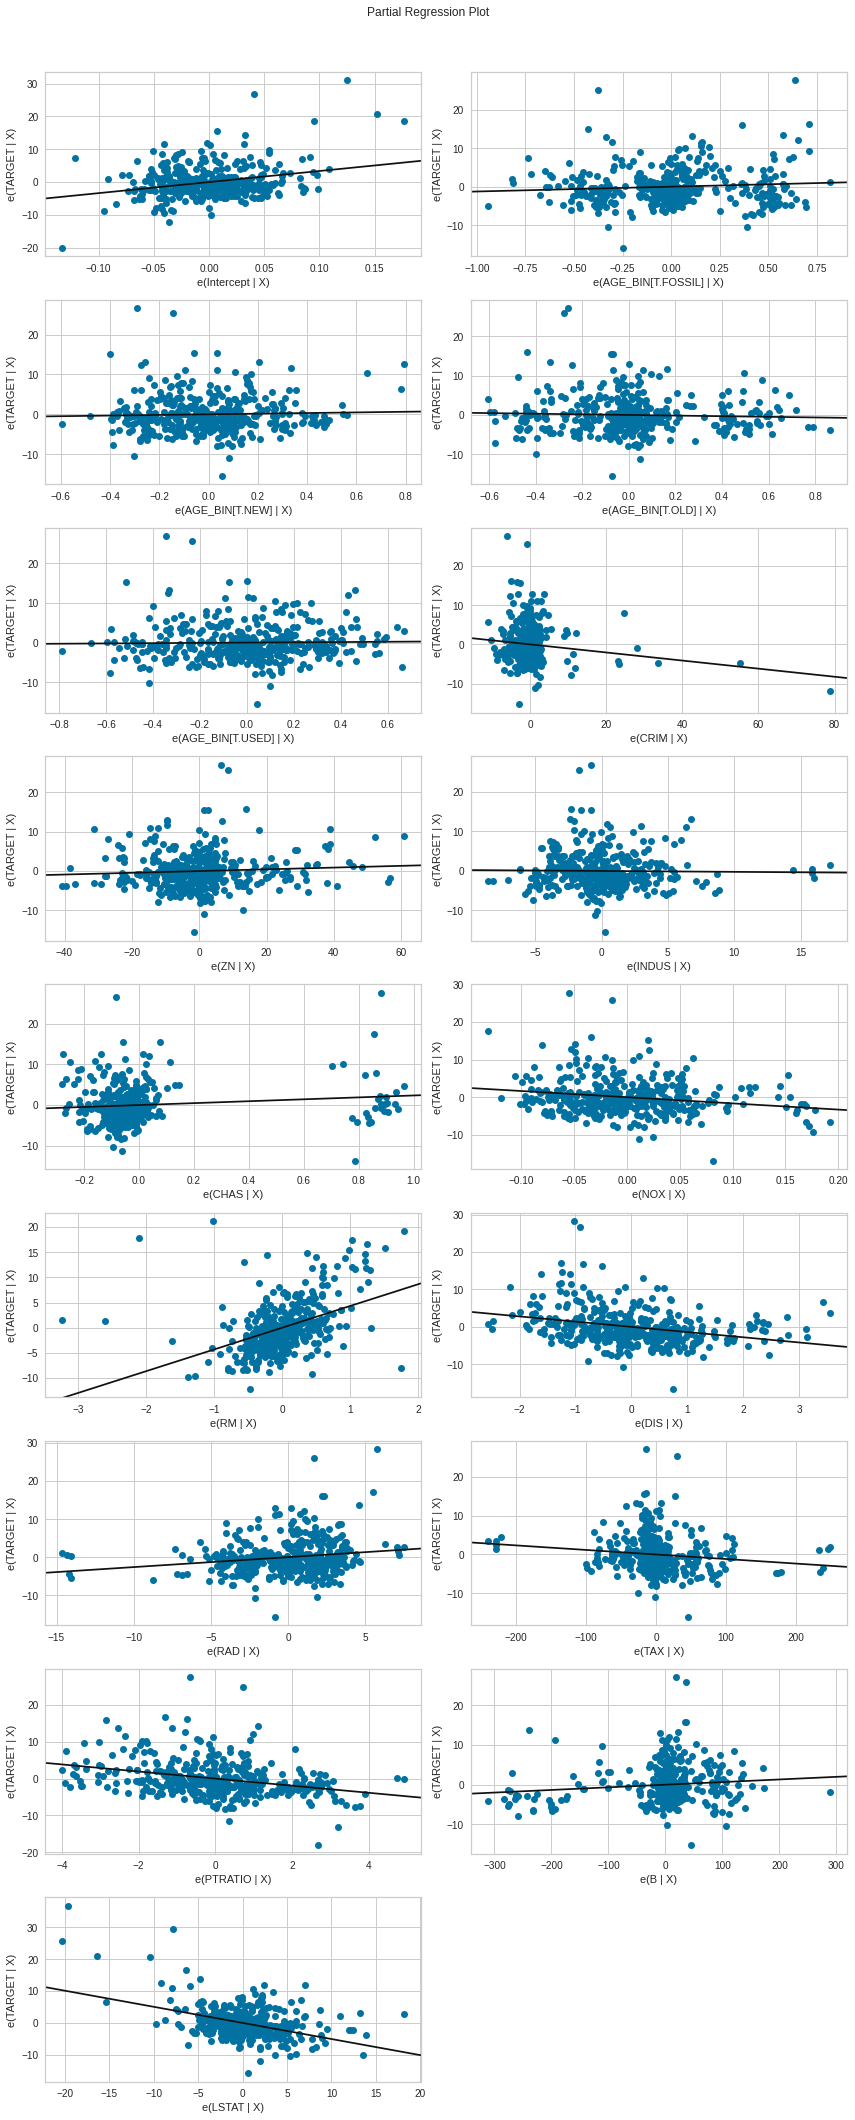

In [18]:
fig = plt.figure(figsize=(12,30))
fig = sm.graphics.plot_partregress_grid(lm, fig=fig)

# Prediction & Confidence Intervals

In [19]:
predictions = lm.get_prediction(X_test)
pred_df = predictions.summary_frame()
pred_df['actual'] = y_test.tolist()
pred_df = pred_df.sort_values('actual')
pred_df = pred_df.reset_index(drop=True)
pred_df

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,actual
0,8.658884,2.089190,4.551300,12.766468,-1.507129,18.824896,5.0
1,11.269043,1.112249,9.082235,13.455851,1.716154,20.821932,7.2
2,13.899752,1.137160,11.663968,16.135536,4.335533,23.463971,7.5
3,14.306300,1.272806,11.803820,16.808781,4.676245,23.936356,8.4
4,2.019358,1.008535,0.036465,4.002251,-7.488924,11.527640,8.8
...,...,...,...,...,...,...,...
97,36.876647,1.015553,34.879956,38.873338,27.365478,46.387816,42.3
98,38.276854,0.902056,36.503311,40.050397,28.810016,47.743692,45.4
99,42.165482,1.255781,39.696475,44.634489,32.544071,51.786893,50.0
100,25.052194,0.861601,23.358190,26.746198,15.599934,34.504453,50.0


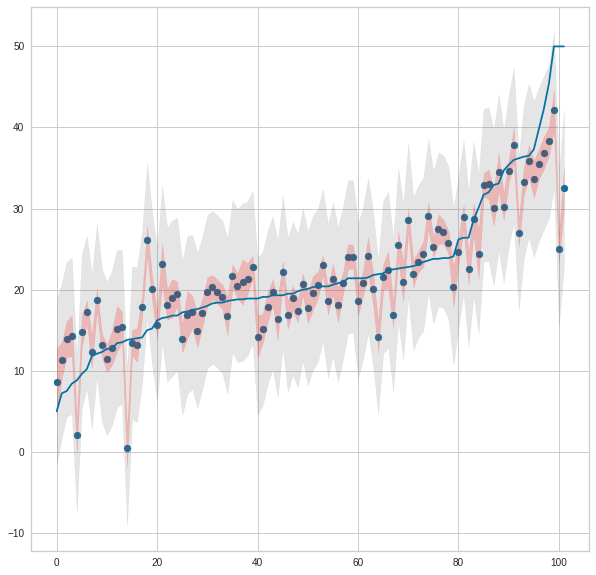

In [20]:
plt.figure(figsize=(10, 10))
plt.plot(pred_df.actual, label='Actual')
plt.scatter(pred_df.index, pred_df['mean'], label='Prediction')
plt.fill_between(pred_df.index, pred_df.obs_ci_lower, pred_df.obs_ci_upper, color='grey', alpha=0.2)
plt.fill_between(pred_df.index, pred_df.mean_ci_lower, pred_df.mean_ci_upper, color='red', alpha=0.2)

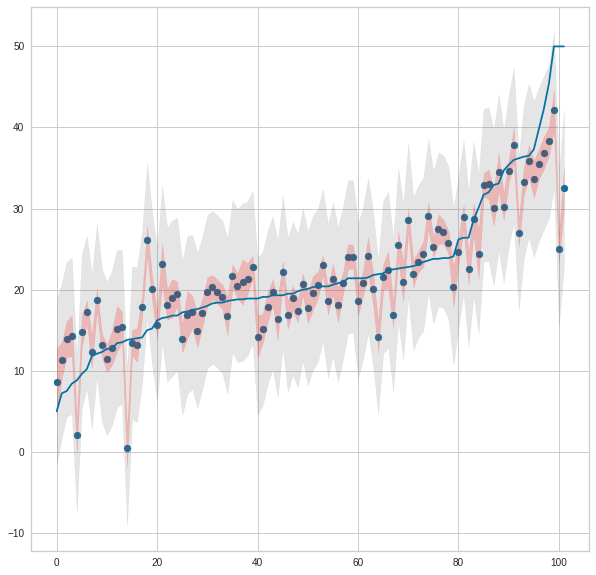

In [21]:
plt.figure(figsize=(10, 10))
plt.plot(pred_df.actual, label='Actual')
plt.scatter(pred_df.index, pred_df['mean'], label='Prediction')
plt.fill_between(pred_df.index, pred_df.obs_ci_lower, pred_df.obs_ci_upper, color='grey', alpha=0.2)
plt.fill_between(pred_df.index, pred_df.mean_ci_lower, pred_df.mean_ci_upper, color='red', alpha=0.2)